# <center> Analysis of Average State Temperature (F) and Homeless Population
    This analysis aims to investigate the potential relationship between the average temperature of a given state within the US and the homeless population, per capita, of the corresponding state.

In [1]:
#%pwd
#set dependancies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import json
from datetime import datetime
import time
import requests
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import linregress
import numpy as np
#API
from config import ncdc_api
headers = {"token":ncdc_api} #token from https://www.ncdc.noaa.gov/cdo-web/token

In [2]:
#paths to csv files
homeless_data = ("Homeless Population by State.csv")
sheltered_data = ("Sheltered Homeless Population.csv")
severe_weather_data = ("Severe Weather Data.csv")

#read csv files
homeless_data = pd.read_csv(homeless_data)
sheltered_data = pd.read_csv(sheltered_data)
severe_weather_data = pd.read_csv(severe_weather_data)

Original Code<br>
    Pulling data with this original code has approximately a 50/50 chance of success. While it does work, a more efficient method for acquiring the requested data was sought after. 

In [3]:
'''
#get a list of states and their ids
url="https://www.ncei.noaa.gov/cdo-web/api/v2/locations?locationcategoryid=ST&limit=52"
r = requests.get(url, "dataset", headers = headers).text
states = json.loads(r) 

#make an api call to get temperature average from Summary of the Year dataset for every station in each state
for i in states['results']:
    if i['id']!="FIPS:11": #breaks on District of Columbia(FIPS:11)? skipping it
        #print(i['name'])
        datasetid='GSOY' #Global Summary of the Year, contains a yearly resolution of meteorological elements 
        datatypeid = "TAVG" #TAVG TMAX TMIN
        locationid=i['id'] #assigning state id which returns all weather stations in its boundry
        units='standard' #standard or metric
        startdate="2021-01-01"
        enddate="2021-12-31" #code cant handle more then one year at a time
        limit="1000" #max is 1000, default is 25

        #make the api call
        url= f"https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid={datasetid}&datatypeid={datatypeid}&locationid={locationid}&units={units}&startdate={startdate}&enddate={enddate}&limit={limit}"
        r = requests.get(url, "dataset", headers = headers).text
        response = json.loads(r)
        
        #get the temp from each weather station, add them up then find average
        tavg=0
        for i in response['results']:
            #print(i['value']) #print value from each station
            tavg += i['value'] 
        tavg = tavg/len(response['results'])
        #print (tavg)
        
        time.sleep(5) #api allows up to 5 requests per second but seems to hang sometimes, limiting to 1 per second
        weather_data.append({"State": state,
                     "Average Temp (2021)": tavg})
'''

'\n#get a list of states and their ids\nurl="https://www.ncei.noaa.gov/cdo-web/api/v2/locations?locationcategoryid=ST&limit=52"\nr = requests.get(url, "dataset", headers = headers).text\nstates = json.loads(r) \n\n#make an api call to get temperature average from Summary of the Year dataset for every station in each state\nfor i in states[\'results\']:\n    if i[\'id\']!="FIPS:11": #breaks on District of Columbia(FIPS:11)? skipping it\n        #print(i[\'name\'])\n        datasetid=\'GSOY\' #Global Summary of the Year, contains a yearly resolution of meteorological elements \n        datatypeid = "TAVG" #TAVG TMAX TMIN\n        locationid=i[\'id\'] #assigning state id which returns all weather stations in its boundry\n        units=\'standard\' #standard or metric\n        startdate="2021-01-01"\n        enddate="2021-12-31" #code cant handle more then one year at a time\n        limit="1000" #max is 1000, default is 25\n\n        #make the api call\n        url= f"https://www.ncdc.noa

More Efficient Code<br>
This code was written with the assistance of an AI language model.<br>
Using the base of the previous code, the "concurrent.futures" module allows for multiple API requests simultaneously, as opposed to running a "for" loop through thousands of rows.<br>
Code has a better success rate, although not 100%.

In [4]:
#define function to fetch temperature data per state
def fetch_temperature_data(state):
    #existing code from original
    #define variables with NOAA specific calls
    datasetid = 'GSOY' #Global Summary of Year
    datatypeid = 'TAVG' #Average Temperature
    locationid = state['id'] #State ID
    units = 'standard' #Units for Temperature (F)
    startdate = '2021-01-01' #Start Date of Requested Data
    enddate = '2021-12-31' #End Date of Requested Data (going over entire year breaks code)
    limit = '1000' #Limit for Data 
    
    #NOAA url with embedded variables
    url = f"https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid={datasetid}&datatypeid={datatypeid}&locationid={locationid}&units={units}&startdate={startdate}&enddate={enddate}&limit={limit}"
    #API request and store data
    r = requests.get(url, headers=headers).text
    response = json.loads(r)
    
    #set temp avg at 0
    tavg = 0
    if "results" in response:
        #run through results and gather temperature values 
        for result in response['results']:
            tavg += result['value']
        #find avg of all NOAA stations' temp data per state
        tavg = tavg / len(response['results'])
    else:
        tavg=None
    time.sleep(1)  # Limit request per second
    
    #return dictionary with state name and average temperature
    return {"State": state['name'], "Average Temp (F)": tavg}

#main script
if __name__ == '__main__':
    # get state information and store in "states" variable
    state_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/locations?locationcategoryid=ST&limit=52"
    state_response = requests.get(state_url, headers=headers).text
    states = json.loads(state_response)['results']

    # ThreadPoolExecutor used to fetch temperature data for each state concurrently
    # adjust max_workers (number of simultaneous requests) as needed
    with ThreadPoolExecutor(max_workers=3) as executor:  
        weather_data = list(executor.map(fetch_temperature_data, states))

    # weather_data now contains the temperature data for all states

In [5]:
#ensure data pulled successfully and create df
weather_data_df = pd.DataFrame(weather_data)
weather_data_df.head()

,State,Average Temp (F)
0,Alabama,63.755000
1,Alaska,30.352143
2,Arizona,59.975949
3,Arkansas,61.046835
4,California,59.257534


In [6]:
#save to csv for merging
weather_data_df.to_csv("weather.csv", index_label="State ID")
#read weather csv into code
weather_data = ("weather.csv")
weather_data = pd.read_csv(weather_data)

In [18]:
#merge all csv files for following analyses
homeless_weather=pd.merge(homeless_data, weather_data_df, how="outer", on=["State"])
homeless_weather_sheltered=pd.merge(homeless_weather, sheltered_data, how="outer", on=["State"])
#homeless_weather_sheltered_severe = "hwss"
hwss=pd.merge(homeless_weather_sheltered, severe_weather_data, how="outer", on=["State"])
#remove "NaN" results (District of Columbia). Weather code didn't like DC
hwss=hwss.dropna()
#reset "states" variable to hold only wanted values (no NaN)
states=hwss["State"]
hwss.head()

,State,Total,Per10kResidents,ChronicallyHomeless,PeopleInFamilyUnits,SoloIndividuals,UnaccompaniedYouths,Veterans,Average Temp (F),sheltered homeless population,percentage of homeless population that is sheltered,days over 90F,Harsh Winter
0,Alabama,3752.0,7.4,539.0,1270.0,2482.0,169.0,308.0,63.755000,2172.0,60.0,42.0,NO
1,Alaska,2320.0,31.7,576.0,560.0,1760.0,186.0,134.0,30.352143,1963.0,85.0,0.0,YES
2,Arizona,13553.0,18.6,2476.0,2846.0,10707.0,917.0,857.0,59.975949,5526.0,41.0,176.0,NO
3,Arkansas,2459.0,8.1,376.0,328.0,2131.0,251.0,92.0,61.046835,1163.0,47.0,66.0,NO
4,California,171521.0,43.7,57760.0,25538.0,145983.0,9590.0,10395.0,59.257534,56030.0,33.0,90.0,NO


# <center> Merged Data Reasoning
The following datasets will compare homelessness per capita to the average temperature of the corresponding US state. To include "total" homless population as opposed to "per capita", could result in skewed data.

In [8]:
#create df containing pertinent information
data = {
    "State":hwss["State"],
    "Total Homeless Population":hwss["Total"],
    "Homeless Per 10k Residents":hwss["Per10kResidents"],
    "Average Temp (F)":hwss["Average Temp (F)"]}
homeless_temp = pd.DataFrame(data)
homeless_temp.head()

,State,Total Homeless Population,Homeless Per 10k Residents,Average Temp (F)
0,Alabama,3752.0,7.4,63.755000
1,Alaska,2320.0,31.7,30.352143
2,Arizona,13553.0,18.6,59.975949
3,Arkansas,2459.0,8.1,61.046835
4,California,171521.0,43.7,59.257534


# <center> Scatter Plot and Linear Regression of Data
    The charts below display the relationship between a US state's average temperature and the homeless population per capita.

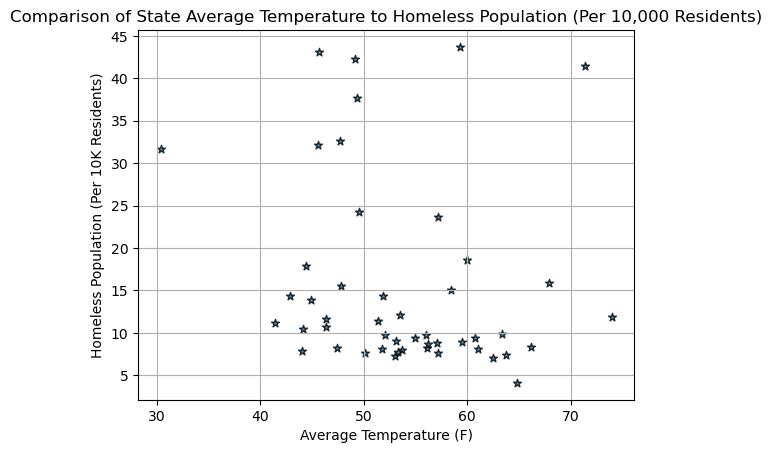

In [9]:
#create scatter plot to display data
plt.scatter(
    homeless_temp["Average Temp (F)"],
    homeless_temp["Homeless Per 10k Residents"],
    edgecolor="black",
    linewidths=1,
    marker="*",
    alpha=0.8
)

plt.title("Comparison of State Average Temperature to Homeless Population (Per 10,000 Residents)")
plt.xlabel("Average Temperature (F)")
plt.ylabel("Homeless Population (Per 10K Residents)")
plt.grid(True)
plt.show()

In [10]:
#line regression (correlation) code
def plot_linear_regression(x_values, y_values, x_axis, title, text_coordinates):
    
    # Compute linear regression
    (slope, intercept, rvalue, pvalue, sterr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Plot
    plt.scatter(x_values,y_values, marker="*")
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,text_coordinates,fontsize=15,color="black")
    plt.xlabel(x_axis)
    plt.ylabel(title)
    print(f"The r² value is: {rvalue**2}")
    print(f"The r value is: {rvalue}")
    print(f"The p value is: {pvalue}")
    plt.grid(True)
    plt.show()

The r² value is: 0.03321674670287708
The r value is: -0.18225462052545358
The p value is: 0.21503899465517873


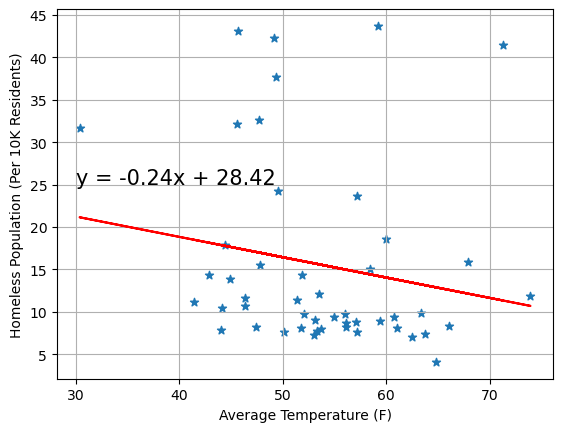

In [11]:
#correlation (or lack of) of data
x_values = homeless_temp["Average Temp (F)"]
y_values = homeless_temp["Homeless Per 10k Residents"]
plot_linear_regression(x_values, y_values, "Average Temperature (F)", "Homeless Population (Per 10K Residents)", (30,25))

As the linear regression analysis shows, there is a negative correlation between a state's average temperature and it's homeless population per capita. This result suggests that, on average, states with a higher average temperature tend to have a lower homeless population per capita.

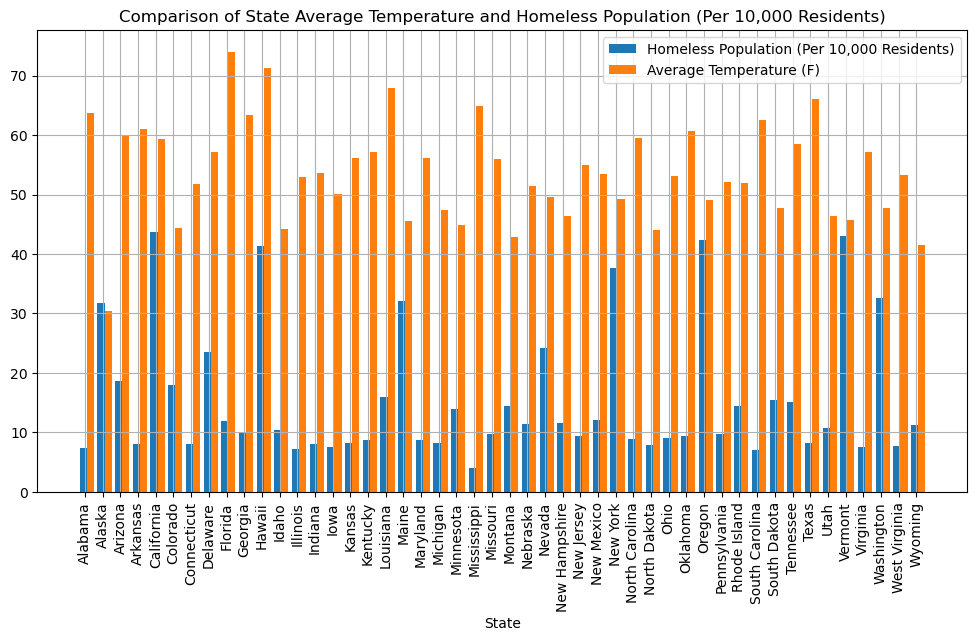

In [12]:
plt.figure(figsize=(12,6))
x=range(len(states))
width=0.4

#create bar graph to show side by side comparison of homeless population (per capita) and average temperature per state 
plt.bar(x, homeless_temp["Homeless Per 10k Residents"], width, label = "Homeless Population (Per 10,000 Residents)")
plt.bar([i+width for i in x], homeless_temp["Average Temp (F)"], width, label = "Average Temperature (F)")
plt.title("Comparison of State Average Temperature and Homeless Population (Per 10,000 Residents)")
plt.xlabel("State")
#label on y-axis unnecessary with provided legend 
plt.ylabel("")
#make state names readable by changing rotation
plt.xticks([i+width/4 for i in x], states, rotation="vertical")
plt.legend()
plt.grid(True)
plt.show()

# <center> Weather Findings
This analysis provides insight into the variation of average temperatures and homeless populations across the US states. The findings of this analysis do show a negative correlation between the two variables, but it is important to note that not all mitigating factors have been explored. Further investigation into severe climate instances, available housing, state-specific legislation, etc. would be needed to determine a comprehensive and conclusive result.

# Severe Weather Analysis

In [13]:
#create df conatining pertinent information and clean up headers
data = {
    "State":hwss["State"],
    "Total Homeless Population":hwss["Total"],
    "Sheltered Homeless Population":hwss["sheltered homeless population"],
    "Homeless Per 10k Residents":hwss["Per10kResidents"],
    "Severe Heat (Days per Year)":hwss["days over 90F"],
    "Harsh Winter":hwss["Harsh Winter"]
}
homeless_weather_merged_df = pd.DataFrame(data)
#create ShelteredPer10k column to calculate sheltered homeless population per 10,000 residents
homeless_weather_merged_df['Sheltered Per 10k Residents'] = \
    hwss['Per10kResidents'] * hwss['sheltered homeless population'] / hwss['Total']
#move columns around
homeless_weather_merged_df=homeless_weather_merged_df[["State", "Total Homeless Population", "Homeless Per 10k Residents", "Sheltered Per 10k Residents", "Severe Heat (Days per Year)", "Harsh Winter"]]
#ensure data pulled and calculated correctly
homeless_weather_merged_df.head()

,State,Total Homeless Population,Homeless Per 10k Residents,Sheltered Per 10k Residents,Severe Heat (Days per Year),Harsh Winter
0,Alabama,3752.0,7.4,4.283795,42.0,NO
1,Alaska,2320.0,31.7,26.822026,0.0,YES
2,Arizona,13553.0,18.6,7.583826,176.0,NO
3,Arkansas,2459.0,8.1,3.830948,66.0,NO
4,California,171521.0,43.7,14.275284,90.0,NO


The r² value is: 0.6535927697773911
The r value is: 0.8084508456161025
The p value is: 3.6844442057722105e-12


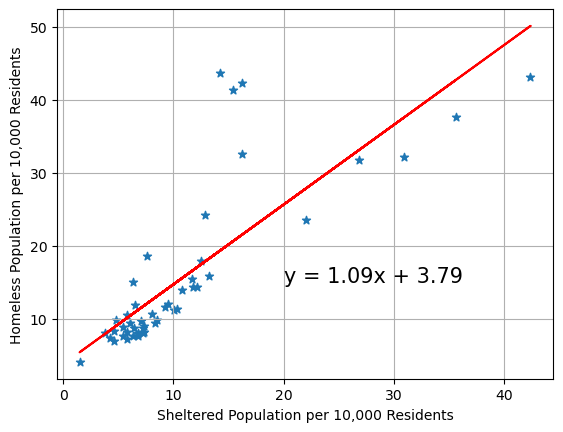

In [14]:
x_values = homeless_weather_merged_df["Sheltered Per 10k Residents"]
y_values = homeless_weather_merged_df["Homeless Per 10k Residents"]
plot_linear_regression(x_values, y_values, "Sheltered Population per 10,000 Residents", "Homeless Population per 10,000 Residents", (20,15))

The r² value is: 0.16672460633653763
The r value is: -0.4083192456112467
The p value is: 0.0039630226308295866


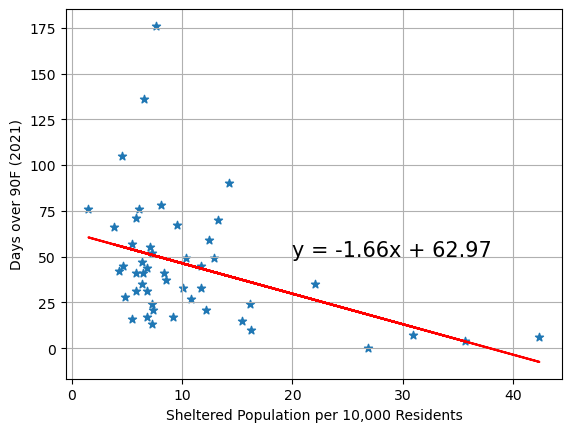

In [15]:
x_values = homeless_weather_merged_df["Sheltered Per 10k Residents"]
y_values = homeless_weather_merged_df["Severe Heat (Days per Year)"]
plot_linear_regression(x_values, y_values, "Sheltered Population per 10,000 Residents", "Days over 90F (2021)", (20, 50))

In [16]:
harsh_winter= hwss.groupby("Harsh Winter")["percentage of homeless population that is sheltered"].mean()
harsh_winter

Harsh Winter
NO     66.714286
YES    84.000000
Name: percentage of homeless population that is sheltered, dtype: float64

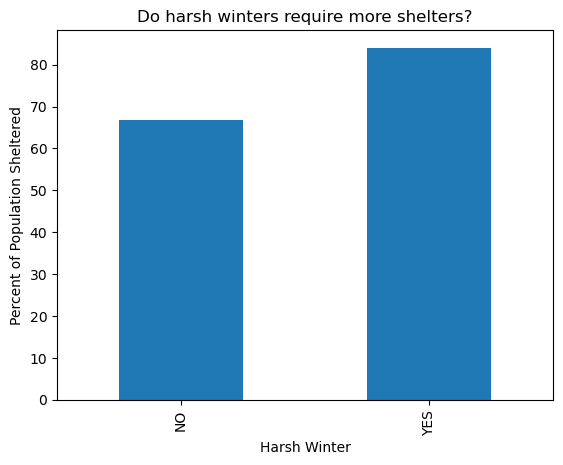

In [17]:
harsh_winter.plot(kind="bar")
plt.xlabel('Harsh Winter')
plt.ylabel('Percent of Population Sheltered')
plt.title('Do harsh winters require more shelters?')
plt.show()